# Data structuring, part III

### The Pandas way

*Andreas Bjerre-Nielsen*

# 10 things I hate about pandas

- Correction: Integers and NaN do work now!
- Check out this [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html) from July 2019.

# Recap

*Which datatypes beyond numeric does pandas handle natively?*

- .

*What can we do to missing values and duplicates?*

- 
- 

## Agenda

1. [the split apply combine framework](#Split-apply-combine)
1. [joining datasets](#Joining-data)
1. [reshaping data](#Reshaping-data)
1. [methods chaining](#Methods-chaining)

## Loading the software and data

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns

tips = sns.load_dataset('tips')
titanic = sns.load_dataset('titanic')

# Reshaping data

## Stacking data

A DataFrame can be collapsed into a Series with the **stack** command:

In [58]:
df = pd.DataFrame([[1,2],[3,4]],columns=['EU','US'],index=[2000,2010])
df.head()
stacked = df.stack() # going from wide to long format 
stacked=stacked.reset_index()
stacked.columns = ['year', 'place', 'value']
stacked.head()

,year,place,value
0,2000,EU,1
1,2000,US,2
2,2010,EU,3
3,2010,US,4


In [59]:
stacked.head()

,year,place,value
0,2000,EU,1
1,2000,US,2
2,2010,EU,3
3,2010,US,4


Note: The stacked DataFrame is in long/tidy format, the original is wide.

## To wide format

Likewise we can transform a long DataFrame with the unstack

In [60]:
print(df.stack())
print()
# print(df.stack().unstack(level=1))

2000  EU    1
      US    2
2010  EU    3
      US    4
dtype: int64



## More stuff

Other cool functions include
- `melt` which only stacks certain columns
- `pivot` which makes you to reshape the dataframe like in Excel

# Split-apply-combine 

## Split-apply-combine (1)
*What is the split-apply-combine framework?*

A procedure to 
1. **split** a DataFrame into subsets of data
2. **apply** certain functions (sorting, mean, other custom stuff)
3. **combine** it back into a DataFrame

Application example: compute mean personal income.

## Split-apply-combine (2)

How do we *split* observations by x and *apply* the calculation mean of y?*

<center><img src='https://raw.githubusercontent.com/abjer/sds2017/master/slides/figures/split-apply-combine.png'></center>

## groupby (1)

A powerful tool in DataFrames is the `groupby` method. Example:

In [61]:
split_var = 'sex'
apply_var = 'total_bill'

tips.groupby(split_var) \
    [apply_var] \
    .mean()
# tips\
#     .groupby(split_var)\
#     [apply_var]\
#     .mean()

sex
Male      20.744076
Female    18.056897
Name: total_bill, dtype: float64

In [62]:
tips.groupby('sex')['tip'].mean()

sex
Male      3.089618
Female    2.833448
Name: tip, dtype: float64

## groupby (2)
*What does the `groupby` method do?*

- It implements *split-apply-combine*

Can other functions be applied?

- Yes: `mean`, `std`, `min`, `max` all work. 
- Using `.apply()` method and inserting your ***homemade*** function works too.

## groupby (3)
*Does `groupby` work for multiple variables, functions?*

In [63]:
grouped = tips.groupby(['sex', 'time'])

grouped.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
11,35.26,5.00,Female,No,Sun,Dinner,4
14,14.83,3.02,Female,No,Sun,Dinner,2
16,10.33,1.67,Female,No,Sun,Dinner,3


In [64]:
split_vars = ['sex', 'time'] 
apply_vars = ['total_bill', 'tip']
apply_fcts = ['mean', 'std', 'median']
combined = tips \
    .groupby(split_vars) \
    [apply_vars] \
    .agg(apply_fcts)

print(combined.reset_index())

      sex    time total_bill                        tip                 
                        mean       std median      mean       std median
0    Male   Lunch  18.048485  7.953435  16.58  2.882121  1.329017   2.31
1    Male  Dinner  21.461452  9.460974  19.63  3.144839  1.529116   3.00
2  Female   Lunch  16.339143  7.500803  13.42  2.582857  1.075108   2.01
3  Female  Dinner  19.213077  8.202085  17.19  3.002115  1.193483   3.00


Note grouping with multiple variables uses a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.MultiIndex.html) which we do not cover.

## groupby (4)
*Can we use `groupby` in a loop?*

Yes, we can iterate over a groupby object. Example:

In [65]:
results = {}
for group, group_df in tips.groupby('sex'):
    #print(group)
    #print(group_df.head())
    group_mean = group_df.total_bill.mean()
    results[group] = group_mean

print("Male (mean): {Male}\nFemale (mean): {Female}".format(**results))

Male (mean): 20.744076433121034
Female (mean): 18.056896551724137


ProTip: `groupby` is an iterable we can also use with `multiprocessing` for parallel computing.

## groupby (5)
*How do we get our `groupby` output into the original dataframe?*

- Option 1: you use `transform`.

- Option 2: you merge it (not recommended)



In [66]:
mu_sex = tips.groupby(split_var)[apply_var].transform('mean')

(tips.total_bill - mu_sex)

0      -1.066897
1     -10.404076
2       0.265924
3       2.935924
4       6.533103
5       4.545924
6     -11.974076
7       6.135924
8      -5.704076
9      -5.964076
10    -10.474076
11     17.203103
12     -5.324076
13     -2.314076
14     -3.226897
15      0.835924
16     -7.726897
17     -4.454076
18     -1.086897
19     -0.094076
20     -2.824076
21      2.233103
22     -2.286897
23     18.675924
24     -0.924076
25     -2.934076
26     -7.374076
27     -8.054076
28      0.955924
29      1.593103
         ...    
214    10.113103
215    -5.156897
216     7.405924
217    -9.154076
218   -13.004076
219    12.083103
220    -8.584076
221    -4.636897
222   -12.164076
223    -2.076897
224    -7.324076
225    -1.786897
226    -7.966897
227    -0.294076
228    -7.464076
229     4.063103
230     3.265924
231    -5.054076
232    -9.134076
233    -9.974076
234    -5.214076
235   -10.674076
236    -8.144076
237    12.085924
238    17.773103
239     8.285924
240     9.123103
241     1.9259

*Why is this useful?*

- Useful for fixed effects computation

# Joining DataFrames

Until now we've worked with one DataFrame at a time.

We will now learn to put them together.

## Some DataFrames
Let's make some data to play with

In [67]:
left_df = pd.DataFrame({'key': ['A', 'B', 'C', 'D'], 'value_left': range(4)})    
right_df = pd.DataFrame({'key': ['C', 'D', 'E', 'F'], 'value_right': range(4,8)})
print(left,'\n', right)

  key  value_left
0   A           0
1   B           1
2   C           2
3   D           3 
   key  value_right
0   C            4
1   D            5
2   E            6
3   F            7


## Merging data
The forthcoming figures all follow this convention:

-  <font color="blue">blue</font>: rows in merge output
-  <font color="red">red</font>: rows excluded from output (i.e., removed)
-  <font color="green">green</font>: missing values replaced with NaNs 

We use `merge` which is pandas function and a method for dataframes.

## Inner merge (default)
This merge only uses only *shared* keys

In [68]:
pd.merge(left_df, right_df, on='key', how='inner')

,key,value_left,value_right
0,C,2,4
1,D,3,5


<center><img src='https://i.stack.imgur.com/YvuOa.png' alt="Drawing" style="width: 600px;"/></center>

## Left merge
This merge uses only *left* keys

In [69]:
pd.merge(left_df, right_df, on='key', how='left')

,key,value_left,value_right
0,A,0,NaN
1,B,1,NaN
2,C,2,4.0
3,D,3,5.0


<center><img src='https://i.stack.imgur.com/BECid.png' alt="Drawing" style="width: 600px;"/></center>

## Right merge
This merge uses only *right* keys

In [70]:
pd.merge(left_df, right_df, on='key', how='right')

,key,value_left,value_right
0,C,2.0,4
1,D,3.0,5
2,E,NaN,6
3,F,NaN,7


<center><img src='https://i.stack.imgur.com/8w1US.png' alt="Drawing" style="width: 600px;"/></center>

## Outer merge
This merge uses *all* keys

In [71]:
pd.merge(left_df, right_df, on='key', how='outer')

,key,value_left,value_right
0,A,0.0,NaN
1,B,1.0,NaN
2,C,2.0,4.0
3,D,3.0,5.0
4,E,NaN,6.0
5,F,NaN,7.0


<center><img src='https://i.stack.imgur.com/euLoe.png' alt="Drawing" style="width: 600px;"/></center>

## Overview of merge types

<center><img src='https://www.dofactory.com/Images/sql-joins.png' alt="Drawing" style="width: 600px;"/></center>

More merge type exists, see [this post](https://stackoverflow.com/questions/53645882/pandas-merging-101) for details.

## Joining DataFrames

We can also join by keys in the index. This is possible with `join` or `concat`:
- both methods work vertically and horizontally.
- `concat` works with  multiple DataFrames at once;

Requirement: overlapping index keys or column names.

In [72]:
df0 = left.set_index('key')
df1 = right.set_index('key')

## Horizontal join 

Works like `merge` where keys is now the index! 

In [73]:
print(df0.join(df1, how='inner'))

     value_left  value_right
key                         
C             2            4
D             3            5


## Vertical join 

`concat` on axis=0 stacks the dataframes on top of each other!

In [74]:
print(pd.concat([df0, df1], join='outer', axis=0, sort=False))

     value_left  value_right
key                         
A           0.0          NaN
B           1.0          NaN
C           2.0          NaN
D           3.0          NaN
C           NaN          4.0
D           NaN          5.0
E           NaN          6.0
F           NaN          7.0


## Vertical and horizontal

An overview of `concat`/`join` operations (left: horizontal, right: vertical)

<center><img src='https://i.stack.imgur.com/1rb1R.jpg' alt="Drawing" style="width: 750px;"/></center>

# Putting it together

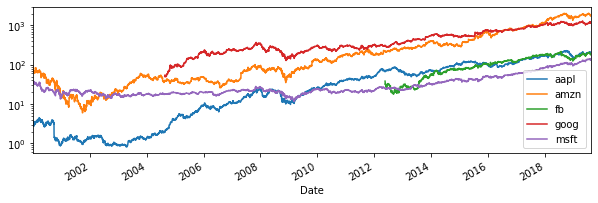

In [76]:
from pandas_datareader import data
stocks = ['aapl', 'goog', 'msft', 'amzn', 'fb']
def load_stock(s):
    return data.DataReader(s, data_source='yahoo', start='2000')['Adj Close']
load_stock('aapl').head()
    stock_dfs = {s:load_stock(s) for s in stocks} # dictionary of all stock price
stock_df = pd.concat(stock_dfs, axis=1) # horizontal join
stock_df.plot(logy=True, figsize=(10,3))

# Methods chaining

## Method chain

We iteratively apply methods on dataframes. Example:

In [77]:
titanic.groupby('sex').survived.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

## Method chain (2)

*Suppose we want to filter out teenagers and adults - is this possible?* 

In [79]:
titanic.query("age < 13")[['age','sex','survived']].head()

,age,sex,survived
7,2.0,male,0
10,4.0,female,1
16,2.0,male,0
24,8.0,female,0
43,3.0,female,1


## Method chain (3)

*And how do we make new variables?* 

In [87]:
def has_sibling(v) -> bool:
    return v.sibsp != 0

# print(titanic.assign(has_sibsp=lambda df: df.sibsp>0)[['sibsp','has_sibsp']].head(10))

print(titanic.assign(has_sibsp=has_sibling)[['sibsp','has_sibsp']].head(10))

   sibsp  has_sibsp
0      1       True
1      1       True
2      0      False
3      1       True
4      0      False
5      0      False
6      0      False
7      3       True
8      0      False
9      1       True


## Method chain (4)

*The lines get very long, what do we do?* 

In [94]:
titanic \
    .query("age >= 13") \
    .groupby('sex') \
    .survived \
    .mean()

sex
female    0.777293
male      0.173077
Name: survived, dtype: float64

In [95]:
titanic \
    .query('age < 13') \
    .groupby('sex') \
    ['survived'] \
    .mean()


sex
female    0.593750
male      0.567568
Name: survived, dtype: float64

# Beyond pandas

If you want more sophisticated data processing tools for big data. 

Single machine
- `multiprocessing` and `joblib` for executing code in parallel (using multiple cores)

Multiple machines (cluster)
- `dask` uses a pandas like syntax, also useful for parallelizing
- `pyspark` is Python based but uses a  (multiple machines)


# The end
[Return to agenda](#Agenda)

# Code for plots
### Load software

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title